In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score


In [3]:
import gc 
gc.collect()

0

In [4]:
import matplotlib.pyplot as plt

def plot_feature_importance_bar(model, feature_names, top_n=15):
    importances = model.feature_importances_
    sorted_idx = importances.argsort()[::-1][:top_n]
    
    plt.figure(figsize=(10, 6))
    plt.barh(
        range(top_n),
        importances[sorted_idx][::-1],
        align='center'
    )
    plt.yticks(range(top_n), [feature_names[i] for i in sorted_idx][::-1])
    plt.xlabel("Importancia")
    plt.title(f"Top {top_n} características más importantes")
    plt.tight_layout()
    plt.show()

def plot_real_vs_pred(y_true, y_pred):
    plt.figure(figsize=(8, 6))
    plt.scatter(y_true, y_pred, alpha=0.5, label="Predicciones", color="navy", edgecolors="k")
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', label="Línea perfecta")
    plt.xlabel("Valor real (N_arribos_intervalo)")
    plt.ylabel("Valor predicho")
    plt.title("Comparación entre predicción y realidad")
    plt.legend()
    plt.tight_layout()
    plt.show()

def print_features_usadas(features):
    print(f"\n🧠 El modelo está usando {len(features)} features:")
    for i, f in enumerate(features, 1):
        print(f"{i:2d}. {f}")

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import HistGradientBoostingRegressor

def root_mean_squared_error(y_true, y_pred):
    return mean_squared_error(y_true, y_pred, squared=False)

def evaluar_modelo(nombre, model, X_train, y_train, X_val, y_val):
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)

    print(f"\nResultados para {nombre}")
    print("Train:")
    print(f"  MAE:  {mean_absolute_error(y_train, y_train_pred):.2f}")
    print(f"  RMSE: {root_mean_squared_error(y_train, y_train_pred):.2f}")
    print(f"  R²:   {r2_score(y_train, y_train_pred):.4f}")
    print("Validation:")
    print(f"  MAE:  {mean_absolute_error(y_val, y_val_pred):.2f}")
    print(f"  RMSE: {root_mean_squared_error(y_val, y_val_pred):.2f}")
    print(f"  R²:   {r2_score(y_val, y_val_pred):.4f}")

df = pd.read_parquet("data/modelado/ds_modelado_FUNCIONA.parquet")
df = df[df["duracion_recorrido"] > 1].copy()

train_mask = (df["año_intervalo"] < 2024) | ((df["año_intervalo"] == 2024) & (df["mes_intervalo"] <= 4))
val_mask = (df["año_intervalo"] == 2024) & (df["mes_intervalo"].between(5, 8))

df_train = df[train_mask].copy()
df_val = df[val_mask].copy()

target = "N_arribos_intervalo"
cols_a_excluir = [
    "N_arribos_intervalo",
    "N_salidas_intervalo",         
    "id_recorrido",
    "id_estacion_destino",
    "barrio_destino",
    "zona_destino_cluster",
    "cantidad_estaciones_cercanas_destino",
    "año_destino", "mes_destino", "dia_destino",
    "hora_destino", "minuto_destino", "segundo_destino",
    "duracion_recorrido",                         
     "fecha_intervalo" ,  "fecha_origen"    
]
features = [col for col in df.columns if col not in cols_a_excluir]

for es_finde_val in [0, 1]:
    nombre_modelo = f"es_finde = {es_finde_val}"

    train_sub = df_train[df_train["es_finde"] == es_finde_val]
    val_sub = df_val[df_val["es_finde"] == es_finde_val]

    X_train = train_sub[features]
    y_train = train_sub[target]

    print(X_train.dtypes[X_train.dtypes == "object"])
    X_train = train_sub[features].astype(np.float32)
    X_val = val_sub[features].astype(np.float32)

    X_val = val_sub[features]
    y_val = val_sub[target]
    y_train = train_sub[target].astype(np.float32)
    y_val = val_sub[target].astype(np.float32)
    model = HistGradientBoostingRegressor(
        loss="poisson",
        learning_rate=0.1,
        max_iter=100,
        max_depth=12,
        early_stopping=True,
        validation_fraction=0.1,
        n_iter_no_change=20,
        random_state=42
    )
    model.fit(X_train, y_train)

    evaluar_modelo(nombre_modelo, model, X_train, y_train, X_val, y_val)

print_features_usadas(features)
plot_feature_importance_bar(model, features)
plot_real_vs_pred(y_val, model.predict(X_val))

Series([], dtype: object)

📊 Resultados para es_finde = 0
Train:
  MAE:  1.30


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  RMSE: 1.79
  R²:   0.4277
Validation:
  MAE:  1.52
  RMSE: 2.44
  R²:   0.5276
Series([], dtype: object)

📊 Resultados para es_finde = 1
Train:
  MAE:  1.47
  RMSE: 2.21
  R²:   0.6709
Validation:
  MAE:  1.17
  RMSE: 1.84
  R²:   0.5137


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score
import numpy as np

import lightgbm as lgb

model_lgb = lgb.LGBMRegressor(
    objective="poisson",
    learning_rate=0.05,
    n_estimators=1000,
    max_depth=17,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

model_lgb.fit(X_train, y_train)
y_pred = model_lgb.predict(X_val)

mae = mean_absolute_error(y_val, y_pred)
rmse = root_mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print("LightGBM Metrics")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.3f}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017882 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2828
[LightGBM] [Info] Number of data points in the train set: 1898469, number of used features: 60
[LightGBM] [Info] Start training from score 1.019778
📈 LightGBM Metrics
MAE: 1.11
RMSE: 1.56
R²: 0.537


In [ ]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import pandas as pd

def entrenar_modelo_por_finde(path_modelado):
    df = pd.read_parquet(path_modelado)
    df.dropna(inplace=True)
    df = df[df["duracion_recorrido"] > 1].copy()

    target = "N_arribos_intervalo"

    cols_a_excluir = [
    "N_arribos_intervalo",
    "N_salidas_intervalo",         
    "id_recorrido",
    "id_estacion_destino",
    "barrio_destino",
    "zona_destino_cluster",
    "cantidad_estaciones_cercanas_destino",
    "año_destino", "mes_destino", "dia_destino",
    "hora_destino", "minuto_destino", "segundo_destino",
    "duracion_recorrido",                         
     "fecha_intervalo" ,  "fecha_origen"    
]

    df_train = df[(df["año_intervalo"] < 2024) | ((df["año_intervalo"] == 2024) & (df["mes_intervalo"] <= 4))].copy()
    df_val = df[(df["año_intervalo"] == 2024) & (df["mes_intervalo"] >= 5)].copy()

    modelos = {}
    y_val_preds = pd.Series(index=df_val.index, dtype=float)

    for es_finde_val in [0, 1]:
        print(f"\nEntrenando modelo para es_finde = {es_finde_val}...")

        df_train_sub = df_train[df_train["es_finde"] == es_finde_val]
        df_val_sub = df_val[df_val["es_finde"] == es_finde_val]

        X_train = df_train_sub.drop(columns=cols_a_excluir + [target])
        y_train = df_train_sub[target]

        X_val = df_val_sub.drop(columns=cols_a_excluir + [target])
        y_val = df_val_sub[target]

        modelo = XGBRegressor(
            n_estimators=800,
            max_depth=15,
            learning_rate=0.05,
            subsample=0.8,
            colsample_bytree=0.8,
            objective="count:poisson",
            random_state=42,
            n_jobs=-1
        )

        modelo.fit(X_train, y_train)
        modelos[es_finde_val] = modelo

        y_train_pred = modelo.predict(X_train)
        print(f"  [Train] MAE: {mean_absolute_error(y_train, y_train_pred):.4f}")
        print(f"  [Train] R² : {r2_score(y_train, y_train_pred):.4f}")

        y_pred = modelo.predict(X_val)
        y_val_preds.loc[df_val_sub.index] = y_pred

    print("\n=== MÉTRICAS VALIDACIÓN GLOBAL ===")
    y_val = df_val[target]
    print("MAE:", mean_absolute_error(y_val, y_val_preds))
    print("R²:", r2_score(y_val, y_val_preds))

    return modelos, df_val, y_val, y_val_preds, X_train

modelos_finde, df_val_finde, y_val_finde, y_val_preds_finde, X_train_finde = entrenar_modelo_por_finde("data/modelado/ds_modelado_FUNCIONA.parquet")


Entrenando modelo para es_finde = 0...
  [Train] MAE: 0.9668
  [Train] R² : 0.6934

Entrenando modelo para es_finde = 1...
  [Train] MAE: 0.6529
  [Train] R² : 0.9426

=== MÉTRICAS VALIDACIÓN GLOBAL ===
MAE: 1.4956385132413568
R²: 0.3129036401275799


🧪 Train size: (5605806, 48), Val size: (233937, 48)


Entrenando VAE:   1%|          | 1/150 [00:18<45:31, 18.33s/it]

📚 Epoch 01 | Train Loss: 8.9488 | Val Loss: 3.8293 | R² val: -0.8857


Entrenando VAE:   1%|▏         | 2/150 [00:35<43:14, 17.53s/it]

📚 Epoch 02 | Train Loss: 4.3489 | Val Loss: 2.5581 | R² val: -0.5688


Entrenando VAE:   2%|▏         | 3/150 [00:51<41:08, 16.79s/it]

📚 Epoch 03 | Train Loss: 2.6598 | Val Loss: 1.6160 | R² val: -0.3560


Entrenando VAE:   3%|▎         | 4/150 [01:05<38:47, 15.94s/it]

📚 Epoch 04 | Train Loss: 1.4966 | Val Loss: 0.9351 | R² val: -0.2262


Entrenando VAE:   3%|▎         | 5/150 [01:20<37:41, 15.60s/it]

📚 Epoch 05 | Train Loss: 0.5906 | Val Loss: 0.5161 | R² val: -0.1508


Entrenando VAE:   4%|▍         | 6/150 [01:35<36:47, 15.33s/it]

📚 Epoch 06 | Train Loss: -0.0243 | Val Loss: 0.2587 | R² val: -0.1000


Entrenando VAE:   5%|▍         | 7/150 [01:50<36:08, 15.16s/it]

📚 Epoch 07 | Train Loss: -0.4229 | Val Loss: 0.0990 | R² val: -0.0664


Entrenando VAE:   5%|▌         | 8/150 [02:05<35:34, 15.03s/it]

📚 Epoch 08 | Train Loss: -0.6894 | Val Loss: -0.0122 | R² val: -0.0351


Entrenando VAE:   6%|▌         | 9/150 [02:19<35:05, 14.93s/it]

📚 Epoch 09 | Train Loss: -0.8753 | Val Loss: -0.0846 | R² val: -0.0083


Entrenando VAE:   7%|▋         | 10/150 [02:34<34:53, 14.96s/it]

📚 Epoch 10 | Train Loss: -1.0110 | Val Loss: -0.1386 | R² val: 0.0181


Entrenando VAE:   7%|▋         | 11/150 [02:50<34:45, 15.00s/it]

📚 Epoch 11 | Train Loss: -1.1100 | Val Loss: -0.1638 | R² val: 0.0289


Entrenando VAE:   8%|▊         | 12/150 [03:04<34:23, 14.95s/it]

📚 Epoch 12 | Train Loss: -1.1869 | Val Loss: -0.1824 | R² val: 0.0373


Entrenando VAE:   9%|▊         | 13/150 [03:19<34:03, 14.92s/it]

📚 Epoch 13 | Train Loss: -1.2457 | Val Loss: -0.1897 | R² val: 0.0330


Entrenando VAE:   9%|▉         | 14/150 [03:34<33:53, 14.95s/it]

📚 Epoch 14 | Train Loss: -1.2906 | Val Loss: -0.1956 | R² val: 0.0270


Entrenando VAE:  10%|█         | 15/150 [03:50<34:06, 15.16s/it]

📚 Epoch 15 | Train Loss: -1.3242 | Val Loss: -0.1818 | R² val: 0.0055


Entrenando VAE:  11%|█         | 16/150 [04:04<33:10, 14.85s/it]

📚 Epoch 16 | Train Loss: -1.3485 | Val Loss: -0.1647 | R² val: -0.0176


Entrenando VAE:  11%|█▏        | 17/150 [04:20<33:30, 15.11s/it]

📚 Epoch 17 | Train Loss: -1.3646 | Val Loss: -0.1418 | R² val: -0.0433


Entrenando VAE:  12%|█▏        | 18/150 [04:36<33:40, 15.30s/it]

📚 Epoch 18 | Train Loss: -1.3733 | Val Loss: -0.1188 | R² val: -0.0681


Entrenando VAE:  13%|█▎        | 19/150 [04:50<32:59, 15.11s/it]

📚 Epoch 19 | Train Loss: -1.3757 | Val Loss: -0.0912 | R² val: -0.0995


Entrenando VAE:  13%|█▎        | 20/150 [05:06<32:55, 15.19s/it]

📚 Epoch 20 | Train Loss: -1.3760 | Val Loss: -0.0689 | R² val: -0.1229


Entrenando VAE:  14%|█▍        | 21/150 [05:20<32:10, 14.96s/it]

📚 Epoch 21 | Train Loss: -1.3734 | Val Loss: -0.0542 | R² val: -0.1406


Entrenando VAE:  15%|█▍        | 22/150 [05:35<32:13, 15.10s/it]

📚 Epoch 22 | Train Loss: -1.3704 | Val Loss: -0.0382 | R² val: -0.1607


Entrenando VAE:  15%|█▌        | 23/150 [05:50<31:53, 15.06s/it]

📚 Epoch 23 | Train Loss: -1.3689 | Val Loss: -0.0276 | R² val: -0.1758


Entrenando VAE:  16%|█▌        | 24/150 [06:05<31:19, 14.92s/it]

📚 Epoch 24 | Train Loss: -1.3652 | Val Loss: -0.0135 | R² val: -0.1977


Entrenando VAE:  17%|█▋        | 25/150 [06:20<31:08, 14.95s/it]

📚 Epoch 25 | Train Loss: -1.3613 | Val Loss: -0.0047 | R² val: -0.2128


Entrenando VAE:  17%|█▋        | 26/150 [06:35<31:14, 15.11s/it]

📚 Epoch 26 | Train Loss: -1.3581 | Val Loss: 0.0048 | R² val: -0.2281


Entrenando VAE:  18%|█▊        | 27/150 [06:51<31:00, 15.12s/it]

📚 Epoch 27 | Train Loss: -1.3544 | Val Loss: 0.0134 | R² val: -0.2401


Entrenando VAE:  19%|█▊        | 28/150 [07:05<30:18, 14.91s/it]

📚 Epoch 28 | Train Loss: -1.3518 | Val Loss: 0.0179 | R² val: -0.2435


Entrenando VAE:  19%|█▉        | 29/150 [07:20<29:54, 14.83s/it]

📚 Epoch 29 | Train Loss: -1.3503 | Val Loss: 0.0185 | R² val: -0.2394


Entrenando VAE:  20%|██        | 30/150 [07:35<29:48, 14.91s/it]

📚 Epoch 30 | Train Loss: -1.3494 | Val Loss: 0.0222 | R² val: -0.2375


Entrenando VAE:  21%|██        | 31/150 [07:49<29:17, 14.77s/it]

📚 Epoch 31 | Train Loss: -1.3491 | Val Loss: 0.0177 | R² val: -0.2282


Entrenando VAE:  21%|██▏       | 32/150 [08:04<29:02, 14.77s/it]

📚 Epoch 32 | Train Loss: -1.3514 | Val Loss: 0.0159 | R² val: -0.2270


Entrenando VAE:  22%|██▏       | 33/150 [08:19<28:48, 14.77s/it]

📚 Epoch 33 | Train Loss: -1.3534 | Val Loss: 0.0123 | R² val: -0.2280


Entrenando VAE:  23%|██▎       | 34/150 [08:34<28:34, 14.78s/it]

📚 Epoch 34 | Train Loss: -1.3569 | Val Loss: 0.0048 | R² val: -0.2257


Entrenando VAE:  23%|██▎       | 35/150 [08:49<28:38, 14.94s/it]

📚 Epoch 35 | Train Loss: -1.3610 | Val Loss: -0.0031 | R² val: -0.2215


Entrenando VAE:  24%|██▍       | 36/150 [09:04<28:20, 14.92s/it]

📚 Epoch 36 | Train Loss: -1.3652 | Val Loss: -0.0110 | R² val: -0.2149


Entrenando VAE:  25%|██▍       | 37/150 [09:19<28:19, 15.04s/it]

📚 Epoch 37 | Train Loss: -1.3701 | Val Loss: -0.0247 | R² val: -0.1981


Entrenando VAE:  25%|██▌       | 38/150 [09:36<29:05, 15.58s/it]

📚 Epoch 38 | Train Loss: -1.3752 | Val Loss: -0.0289 | R² val: -0.1941


Entrenando VAE:  26%|██▌       | 39/150 [09:51<28:37, 15.48s/it]

📚 Epoch 39 | Train Loss: -1.3788 | Val Loss: -0.0425 | R² val: -0.1796


Entrenando VAE:  27%|██▋       | 40/150 [10:06<28:01, 15.29s/it]

📚 Epoch 40 | Train Loss: -1.3845 | Val Loss: -0.0552 | R² val: -0.1661


Entrenando VAE:  27%|██▋       | 41/150 [10:21<27:37, 15.21s/it]

📚 Epoch 41 | Train Loss: -1.3896 | Val Loss: -0.0653 | R² val: -0.1549


Entrenando VAE:  28%|██▊       | 42/150 [10:36<27:28, 15.27s/it]

📚 Epoch 42 | Train Loss: -1.3945 | Val Loss: -0.0701 | R² val: -0.1521


Entrenando VAE:  29%|██▊       | 43/150 [10:51<27:03, 15.17s/it]

📚 Epoch 43 | Train Loss: -1.3997 | Val Loss: -0.0875 | R² val: -0.1292


Entrenando VAE:  29%|██▉       | 44/150 [11:06<26:43, 15.13s/it]

📚 Epoch 44 | Train Loss: -1.4041 | Val Loss: -0.0936 | R² val: -0.1254


Entrenando VAE:  30%|███       | 45/150 [11:21<26:09, 14.94s/it]

📚 Epoch 45 | Train Loss: -1.4083 | Val Loss: -0.1062 | R² val: -0.1102


Entrenando VAE:  31%|███       | 46/150 [11:36<25:48, 14.89s/it]

📚 Epoch 46 | Train Loss: -1.4124 | Val Loss: -0.1126 | R² val: -0.1052


Entrenando VAE:  31%|███▏      | 47/150 [11:50<25:27, 14.83s/it]

📚 Epoch 47 | Train Loss: -1.4159 | Val Loss: -0.1243 | R² val: -0.0944


Entrenando VAE:  32%|███▏      | 48/150 [12:06<25:36, 15.07s/it]

📚 Epoch 48 | Train Loss: -1.4191 | Val Loss: -0.1332 | R² val: -0.0860


Entrenando VAE:  33%|███▎      | 49/150 [12:21<25:08, 14.93s/it]

📚 Epoch 49 | Train Loss: -1.4229 | Val Loss: -0.1409 | R² val: -0.0790


Entrenando VAE:  33%|███▎      | 50/150 [12:36<24:54, 14.95s/it]

📚 Epoch 50 | Train Loss: -1.4258 | Val Loss: -0.1478 | R² val: -0.0717


Entrenando VAE:  34%|███▍      | 51/150 [12:50<24:32, 14.87s/it]

📚 Epoch 51 | Train Loss: -1.4289 | Val Loss: -0.1562 | R² val: -0.0632


Entrenando VAE:  35%|███▍      | 52/150 [13:06<24:42, 15.12s/it]

📚 Epoch 52 | Train Loss: -1.4294 | Val Loss: -0.1605 | R² val: -0.0603


Entrenando VAE:  35%|███▌      | 53/150 [13:21<24:18, 15.03s/it]

📚 Epoch 53 | Train Loss: -1.4325 | Val Loss: -0.1718 | R² val: -0.0493


Entrenando VAE:  36%|███▌      | 54/150 [13:36<24:15, 15.17s/it]

📚 Epoch 54 | Train Loss: -1.4345 | Val Loss: -0.1783 | R² val: -0.0422


Entrenando VAE:  37%|███▋      | 55/150 [13:51<23:47, 15.02s/it]

📚 Epoch 55 | Train Loss: -1.4350 | Val Loss: -0.1815 | R² val: -0.0420


Entrenando VAE:  37%|███▋      | 56/150 [14:06<23:20, 14.90s/it]

📚 Epoch 56 | Train Loss: -1.4375 | Val Loss: -0.1879 | R² val: -0.0343


Entrenando VAE:  38%|███▊      | 57/150 [14:21<23:09, 14.95s/it]

📚 Epoch 57 | Train Loss: -1.4390 | Val Loss: -0.1905 | R² val: -0.0329


Entrenando VAE:  39%|███▊      | 58/150 [14:35<22:46, 14.85s/it]

📚 Epoch 58 | Train Loss: -1.4398 | Val Loss: -0.1952 | R² val: -0.0290


Entrenando VAE:  39%|███▉      | 59/150 [14:50<22:31, 14.85s/it]

📚 Epoch 59 | Train Loss: -1.4407 | Val Loss: -0.2022 | R² val: -0.0225


Entrenando VAE:  40%|████      | 60/150 [15:05<22:11, 14.80s/it]

📚 Epoch 60 | Train Loss: -1.4419 | Val Loss: -0.2042 | R² val: -0.0203


Entrenando VAE:  41%|████      | 61/150 [15:20<21:55, 14.79s/it]

📚 Epoch 61 | Train Loss: -1.4422 | Val Loss: -0.2090 | R² val: -0.0171


Entrenando VAE:  41%|████▏     | 62/150 [15:34<21:38, 14.75s/it]

📚 Epoch 62 | Train Loss: -1.4427 | Val Loss: -0.2126 | R² val: -0.0120


Entrenando VAE:  42%|████▏     | 63/150 [15:49<21:29, 14.82s/it]

📚 Epoch 63 | Train Loss: -1.4433 | Val Loss: -0.2110 | R² val: -0.0139


Entrenando VAE:  43%|████▎     | 64/150 [16:04<21:15, 14.83s/it]

📚 Epoch 64 | Train Loss: -1.4443 | Val Loss: -0.2137 | R² val: -0.0120


Entrenando VAE:  43%|████▎     | 65/150 [16:19<20:55, 14.77s/it]

📚 Epoch 65 | Train Loss: -1.4440 | Val Loss: -0.2179 | R² val: -0.0103


Entrenando VAE:  44%|████▍     | 66/150 [16:33<20:39, 14.76s/it]

📚 Epoch 66 | Train Loss: -1.4445 | Val Loss: -0.2163 | R² val: -0.0135


Entrenando VAE:  45%|████▍     | 67/150 [16:49<20:45, 15.01s/it]

📚 Epoch 67 | Train Loss: -1.4460 | Val Loss: -0.2200 | R² val: -0.0092


Entrenando VAE:  45%|████▌     | 68/150 [17:04<20:21, 14.90s/it]

📚 Epoch 68 | Train Loss: -1.4467 | Val Loss: -0.2210 | R² val: -0.0091


Entrenando VAE:  46%|████▌     | 69/150 [17:18<20:00, 14.82s/it]

📚 Epoch 69 | Train Loss: -1.4465 | Val Loss: -0.2218 | R² val: -0.0091


Entrenando VAE:  47%|████▋     | 70/150 [17:33<19:54, 14.93s/it]

📚 Epoch 70 | Train Loss: -1.4469 | Val Loss: -0.2219 | R² val: -0.0091


Entrenando VAE:  47%|████▋     | 71/150 [17:49<19:44, 14.99s/it]

📚 Epoch 71 | Train Loss: -1.4475 | Val Loss: -0.2249 | R² val: -0.0045


Entrenando VAE:  48%|████▊     | 72/150 [18:04<19:30, 15.01s/it]

📚 Epoch 72 | Train Loss: -1.4479 | Val Loss: -0.2245 | R² val: -0.0060


Entrenando VAE:  49%|████▊     | 73/150 [18:18<19:04, 14.86s/it]

📚 Epoch 73 | Train Loss: -1.4488 | Val Loss: -0.2256 | R² val: -0.0048


Entrenando VAE:  49%|████▉     | 74/150 [18:33<18:39, 14.73s/it]

📚 Epoch 74 | Train Loss: -1.4483 | Val Loss: -0.2235 | R² val: -0.0079


Entrenando VAE:  50%|█████     | 75/150 [18:47<18:20, 14.67s/it]

📚 Epoch 75 | Train Loss: -1.4494 | Val Loss: -0.2248 | R² val: -0.0062


Entrenando VAE:  51%|█████     | 76/150 [19:02<18:09, 14.73s/it]

📚 Epoch 76 | Train Loss: -1.4497 | Val Loss: -0.2212 | R² val: -0.0126


Entrenando VAE:  51%|█████▏    | 77/150 [19:17<18:03, 14.84s/it]

📚 Epoch 77 | Train Loss: -1.4508 | Val Loss: -0.2213 | R² val: -0.0121


Entrenando VAE:  52%|█████▏    | 78/150 [19:32<17:47, 14.82s/it]

📚 Epoch 78 | Train Loss: -1.4502 | Val Loss: -0.2242 | R² val: -0.0079


Entrenando VAE:  53%|█████▎    | 79/150 [19:46<17:22, 14.69s/it]

📚 Epoch 79 | Train Loss: -1.4504 | Val Loss: -0.2199 | R² val: -0.0140


Entrenando VAE:  53%|█████▎    | 80/150 [20:08<19:29, 16.70s/it]

📚 Epoch 80 | Train Loss: -1.4520 | Val Loss: -0.2237 | R² val: -0.0107


Entrenando VAE:  54%|█████▍    | 81/150 [20:23<18:46, 16.32s/it]

📚 Epoch 81 | Train Loss: -1.4519 | Val Loss: -0.2187 | R² val: -0.0153


Entrenando VAE:  55%|█████▍    | 82/150 [20:38<17:56, 15.83s/it]

📚 Epoch 82 | Train Loss: -1.4521 | Val Loss: -0.2206 | R² val: -0.0145


Entrenando VAE:  55%|█████▌    | 83/150 [20:53<17:19, 15.51s/it]

📚 Epoch 83 | Train Loss: -1.4524 | Val Loss: -0.2187 | R² val: -0.0154


Entrenando VAE:  56%|█████▌    | 84/150 [21:08<16:53, 15.36s/it]

📚 Epoch 84 | Train Loss: -1.4531 | Val Loss: -0.2208 | R² val: -0.0139


Entrenando VAE:  57%|█████▋    | 85/150 [21:22<16:25, 15.16s/it]

📚 Epoch 85 | Train Loss: -1.4540 | Val Loss: -0.2200 | R² val: -0.0145


Entrenando VAE:  57%|█████▋    | 86/150 [21:37<15:59, 15.00s/it]

📚 Epoch 86 | Train Loss: -1.4541 | Val Loss: -0.2166 | R² val: -0.0186


Entrenando VAE:  58%|█████▊    | 87/150 [21:53<15:57, 15.20s/it]

📚 Epoch 87 | Train Loss: -1.4549 | Val Loss: -0.2177 | R² val: -0.0161


Entrenando VAE:  59%|█████▊    | 88/150 [22:08<15:41, 15.18s/it]

📚 Epoch 88 | Train Loss: -1.4546 | Val Loss: -0.2179 | R² val: -0.0177


Entrenando VAE:  59%|█████▉    | 89/150 [22:23<15:22, 15.13s/it]

📚 Epoch 89 | Train Loss: -1.4556 | Val Loss: -0.2151 | R² val: -0.0211


Entrenando VAE:  60%|██████    | 90/150 [22:39<15:31, 15.53s/it]

📚 Epoch 90 | Train Loss: -1.4547 | Val Loss: -0.2171 | R² val: -0.0170


Entrenando VAE:  61%|██████    | 91/150 [22:53<14:53, 15.15s/it]

📚 Epoch 91 | Train Loss: -1.4566 | Val Loss: -0.2167 | R² val: -0.0169


Entrenando VAE:  61%|██████▏   | 92/150 [23:08<14:27, 14.96s/it]

📚 Epoch 92 | Train Loss: -1.4565 | Val Loss: -0.2160 | R² val: -0.0174


Entrenando VAE:  62%|██████▏   | 93/150 [23:22<14:03, 14.81s/it]

📚 Epoch 93 | Train Loss: -1.4565 | Val Loss: -0.2168 | R² val: -0.0174


Entrenando VAE:  63%|██████▎   | 94/150 [23:37<13:44, 14.72s/it]

📚 Epoch 94 | Train Loss: -1.4570 | Val Loss: -0.2153 | R² val: -0.0193


Entrenando VAE:  63%|██████▎   | 95/150 [23:52<13:34, 14.82s/it]

📚 Epoch 95 | Train Loss: -1.4577 | Val Loss: -0.2150 | R² val: -0.0195


Entrenando VAE:  64%|██████▍   | 96/150 [24:07<13:22, 14.86s/it]

📚 Epoch 96 | Train Loss: -1.4584 | Val Loss: -0.2158 | R² val: -0.0180


Entrenando VAE:  65%|██████▍   | 97/150 [24:22<13:07, 14.86s/it]

📚 Epoch 97 | Train Loss: -1.4584 | Val Loss: -0.2155 | R² val: -0.0186


Entrenando VAE:  65%|██████▌   | 98/150 [24:36<12:46, 14.74s/it]

📚 Epoch 98 | Train Loss: -1.4591 | Val Loss: -0.2139 | R² val: -0.0201


Entrenando VAE:  66%|██████▌   | 99/150 [24:51<12:33, 14.78s/it]

📚 Epoch 99 | Train Loss: -1.4600 | Val Loss: -0.2163 | R² val: -0.0175


Entrenando VAE:  67%|██████▋   | 100/150 [25:06<12:22, 14.84s/it]

📚 Epoch 100 | Train Loss: -1.4602 | Val Loss: -0.2130 | R² val: -0.0224


Entrenando VAE:  67%|██████▋   | 101/150 [25:20<12:01, 14.72s/it]

📚 Epoch 101 | Train Loss: -1.4609 | Val Loss: -0.2143 | R² val: -0.0195


Entrenando VAE:  68%|██████▊   | 102/150 [25:35<11:43, 14.66s/it]

📚 Epoch 102 | Train Loss: -1.4609 | Val Loss: -0.2148 | R² val: -0.0193


Entrenando VAE:  69%|██████▊   | 103/150 [25:49<11:21, 14.51s/it]

📚 Epoch 103 | Train Loss: -1.4613 | Val Loss: -0.2160 | R² val: -0.0176


Entrenando VAE:  69%|██████▉   | 104/150 [26:04<11:10, 14.58s/it]

📚 Epoch 104 | Train Loss: -1.4619 | Val Loss: -0.2140 | R² val: -0.0191


Entrenando VAE:  70%|███████   | 105/150 [26:18<10:55, 14.57s/it]

📚 Epoch 105 | Train Loss: -1.4613 | Val Loss: -0.2177 | R² val: -0.0155


Entrenando VAE:  71%|███████   | 106/150 [26:33<10:44, 14.64s/it]

📚 Epoch 106 | Train Loss: -1.4622 | Val Loss: -0.2168 | R² val: -0.0146


Entrenando VAE:  71%|███████▏  | 107/150 [26:48<10:32, 14.70s/it]

📚 Epoch 107 | Train Loss: -1.4626 | Val Loss: -0.2167 | R² val: -0.0160


Entrenando VAE:  72%|███████▏  | 108/150 [27:02<10:13, 14.60s/it]

📚 Epoch 108 | Train Loss: -1.4637 | Val Loss: -0.2168 | R² val: -0.0166


Entrenando VAE:  73%|███████▎  | 109/150 [27:17<09:57, 14.58s/it]

📚 Epoch 109 | Train Loss: -1.4637 | Val Loss: -0.2163 | R² val: -0.0158


Entrenando VAE:  73%|███████▎  | 110/150 [27:32<09:53, 14.84s/it]

📚 Epoch 110 | Train Loss: -1.4636 | Val Loss: -0.2152 | R² val: -0.0185


Entrenando VAE:  74%|███████▍  | 111/150 [27:47<09:34, 14.72s/it]

📚 Epoch 111 | Train Loss: -1.4654 | Val Loss: -0.2145 | R² val: -0.0184


Entrenando VAE:  75%|███████▍  | 112/150 [28:02<09:21, 14.77s/it]

📚 Epoch 112 | Train Loss: -1.4647 | Val Loss: -0.2181 | R² val: -0.0139


Entrenando VAE:  75%|███████▌  | 113/150 [28:22<10:01, 16.27s/it]

📚 Epoch 113 | Train Loss: -1.4649 | Val Loss: -0.2157 | R² val: -0.0177


Entrenando VAE:  76%|███████▌  | 114/150 [28:37<09:34, 15.95s/it]

📚 Epoch 114 | Train Loss: -1.4656 | Val Loss: -0.2169 | R² val: -0.0164


Entrenando VAE:  77%|███████▋  | 115/150 [28:52<09:12, 15.78s/it]

📚 Epoch 115 | Train Loss: -1.4665 | Val Loss: -0.2175 | R² val: -0.0148


Entrenando VAE:  77%|███████▋  | 116/150 [29:07<08:51, 15.64s/it]

📚 Epoch 116 | Train Loss: -1.4656 | Val Loss: -0.2171 | R² val: -0.0153


Entrenando VAE:  78%|███████▊  | 117/150 [29:22<08:28, 15.41s/it]

📚 Epoch 117 | Train Loss: -1.4673 | Val Loss: -0.2181 | R² val: -0.0145


Entrenando VAE:  79%|███████▊  | 118/150 [29:37<08:09, 15.31s/it]

📚 Epoch 118 | Train Loss: -1.4672 | Val Loss: -0.2166 | R² val: -0.0150


Entrenando VAE:  79%|███████▉  | 119/150 [29:52<07:51, 15.20s/it]

📚 Epoch 119 | Train Loss: -1.4674 | Val Loss: -0.2191 | R² val: -0.0128


Entrenando VAE:  80%|████████  | 120/150 [30:07<07:34, 15.14s/it]

📚 Epoch 120 | Train Loss: -1.4679 | Val Loss: -0.2190 | R² val: -0.0120


Entrenando VAE:  81%|████████  | 121/150 [30:22<07:15, 15.02s/it]

📚 Epoch 121 | Train Loss: -1.4685 | Val Loss: -0.2174 | R² val: -0.0162


Entrenando VAE:  81%|████████▏ | 122/150 [30:37<06:57, 14.90s/it]

📚 Epoch 122 | Train Loss: -1.4683 | Val Loss: -0.2180 | R² val: -0.0154


Entrenando VAE:  82%|████████▏ | 123/150 [30:51<06:40, 14.83s/it]

📚 Epoch 123 | Train Loss: -1.4691 | Val Loss: -0.2182 | R² val: -0.0139


Entrenando VAE:  83%|████████▎ | 124/150 [31:06<06:25, 14.85s/it]

📚 Epoch 124 | Train Loss: -1.4691 | Val Loss: -0.2207 | R² val: -0.0090


Entrenando VAE:  83%|████████▎ | 125/150 [31:21<06:10, 14.81s/it]

📚 Epoch 125 | Train Loss: -1.4702 | Val Loss: -0.2197 | R² val: -0.0118


Entrenando VAE:  84%|████████▍ | 126/150 [31:36<05:54, 14.79s/it]

📚 Epoch 126 | Train Loss: -1.4696 | Val Loss: -0.2177 | R² val: -0.0139


Entrenando VAE:  85%|████████▍ | 127/150 [31:51<05:42, 14.90s/it]

📚 Epoch 127 | Train Loss: -1.4717 | Val Loss: -0.2199 | R² val: -0.0109


Entrenando VAE:  85%|████████▌ | 128/150 [32:06<05:31, 15.05s/it]

📚 Epoch 128 | Train Loss: -1.4708 | Val Loss: -0.2191 | R² val: -0.0122


Entrenando VAE:  86%|████████▌ | 129/150 [32:21<05:15, 15.02s/it]

📚 Epoch 129 | Train Loss: -1.4718 | Val Loss: -0.2172 | R² val: -0.0153


Entrenando VAE:  87%|████████▋ | 130/150 [32:37<05:02, 15.14s/it]

📚 Epoch 130 | Train Loss: -1.4723 | Val Loss: -0.2175 | R² val: -0.0098


Entrenando VAE:  87%|████████▋ | 131/150 [32:52<04:46, 15.07s/it]

📚 Epoch 131 | Train Loss: -1.4725 | Val Loss: -0.2176 | R² val: -0.0160


Entrenando VAE:  88%|████████▊ | 132/150 [33:06<04:28, 14.94s/it]

📚 Epoch 132 | Train Loss: -1.4716 | Val Loss: -0.2099 | R² val: -0.0062


Entrenando VAE:  89%|████████▊ | 133/150 [33:21<04:15, 15.00s/it]

📚 Epoch 133 | Train Loss: -1.4709 | Val Loss: -0.2083 | R² val: -0.0275


Entrenando VAE:  89%|████████▉ | 134/150 [33:37<04:05, 15.35s/it]

📚 Epoch 134 | Train Loss: -1.4705 | Val Loss: -0.2127 | R² val: -0.0097


Entrenando VAE:  90%|█████████ | 135/150 [33:53<03:49, 15.28s/it]

📚 Epoch 135 | Train Loss: -1.4716 | Val Loss: -0.2177 | R² val: -0.0143


Entrenando VAE:  91%|█████████ | 136/150 [34:09<03:36, 15.49s/it]

📚 Epoch 136 | Train Loss: -1.4731 | Val Loss: -0.2146 | R² val: -0.0219


Entrenando VAE:  91%|█████████▏| 137/150 [34:24<03:20, 15.39s/it]

📚 Epoch 137 | Train Loss: -1.4724 | Val Loss: -0.2134 | R² val: -0.0056


Entrenando VAE:  92%|█████████▏| 138/150 [34:39<03:02, 15.25s/it]

📚 Epoch 138 | Train Loss: -1.4720 | Val Loss: -0.2218 | R² val: -0.0106


Entrenando VAE:  93%|█████████▎| 139/150 [34:59<03:05, 16.87s/it]

📚 Epoch 139 | Train Loss: -1.4756 | Val Loss: -0.2152 | R² val: -0.0203


Entrenando VAE:  93%|█████████▎| 140/150 [35:19<02:56, 17.67s/it]

📚 Epoch 140 | Train Loss: -1.4744 | Val Loss: -0.2153 | R² val: -0.0053


Entrenando VAE:  94%|█████████▍| 141/150 [35:35<02:34, 17.12s/it]

📚 Epoch 141 | Train Loss: -1.4742 | Val Loss: -0.2192 | R² val: -0.0162


Entrenando VAE:  95%|█████████▍| 142/150 [35:50<02:11, 16.47s/it]

📚 Epoch 142 | Train Loss: -1.4749 | Val Loss: -0.2205 | R² val: -0.0107


Entrenando VAE:  95%|█████████▌| 143/150 [36:05<01:53, 16.15s/it]

📚 Epoch 143 | Train Loss: -1.4760 | Val Loss: -0.2164 | R² val: -0.0059


Entrenando VAE:  96%|█████████▌| 144/150 [36:20<01:34, 15.79s/it]

📚 Epoch 144 | Train Loss: -1.4756 | Val Loss: -0.2179 | R² val: -0.0164


Entrenando VAE:  97%|█████████▋| 145/150 [36:35<01:17, 15.49s/it]

📚 Epoch 145 | Train Loss: -1.4767 | Val Loss: -0.2225 | R² val: -0.0068


Entrenando VAE:  97%|█████████▋| 146/150 [36:50<01:01, 15.49s/it]

📚 Epoch 146 | Train Loss: -1.4771 | Val Loss: -0.2202 | R² val: -0.0048


Entrenando VAE:  98%|█████████▊| 147/150 [37:06<00:47, 15.68s/it]

📚 Epoch 147 | Train Loss: -1.4772 | Val Loss: -0.2189 | R² val: -0.0161


Entrenando VAE:  99%|█████████▊| 148/150 [37:21<00:30, 15.43s/it]

📚 Epoch 148 | Train Loss: -1.4771 | Val Loss: -0.2245 | R² val: -0.0020


Entrenando VAE:  99%|█████████▉| 149/150 [37:36<00:15, 15.26s/it]

📚 Epoch 149 | Train Loss: -1.4774 | Val Loss: -0.2217 | R² val: -0.0072


Entrenando VAE: 100%|██████████| 150/150 [37:51<00:00, 15.14s/it]

📚 Epoch 150 | Train Loss: -1.4789 | Val Loss: -0.2183 | R² val: -0.0167


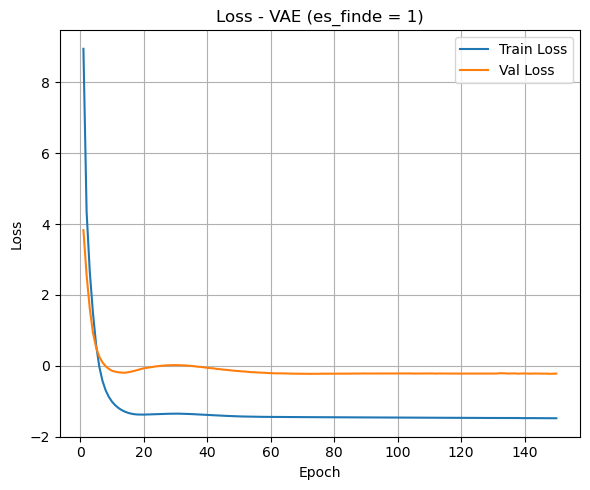

In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from tqdm import trange

LATENT_DIM = 10
HIDDEN_DIM = 128
EPOCHS = 150
LR = 0.01

class VAE_Poisson(nn.Module):
    def __init__(self, input_dim, latent_dim=LATENT_DIM, hidden_dim=HIDDEN_DIM):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
            nn.Softplus(beta=5)  
        )

    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        lambda_pred = self.decoder(z).squeeze(-1)
        return lambda_pred, mu, logvar

def poisson_vae_loss(y_true, lambda_pred, mu, logvar):
    lambda_pred = torch.clamp(lambda_pred, min=1e-4)  # evitar log(0)
    poisson_nll = lambda_pred - y_true * torch.log(lambda_pred)
    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1)
    return (poisson_nll + kl).mean()

def entrenar_vae(X_train_np, y_train_np, X_val_np, y_val_np):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_np)
    X_val_scaled = scaler.transform(X_val_np)

    X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
    X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train_np, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val_np, dtype=torch.float32)

    model = VAE_Poisson(input_dim=X_train_tensor.shape[1])
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)

    train_losses = []
    val_losses = []

    for epoch in trange(1, EPOCHS + 1, desc="Entrenando VAE"):
        model.train()
        optimizer.zero_grad()
        lambda_pred, mu, logvar = model(X_train_tensor)
        loss = poisson_vae_loss(y_train_tensor, lambda_pred, mu, logvar)
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            val_pred, mu_val, logvar_val = model(X_val_tensor)
            val_loss = poisson_vae_loss(y_val_tensor, val_pred, mu_val, logvar_val)
            val_r2 = r2_score(y_val_np, val_pred.numpy())

        train_losses.append(loss.item())
        val_losses.append(val_loss.item())

        print(f"📚 Epoch {epoch:02d} | Train Loss: {loss.item():.4f} | Val Loss: {val_loss.item():.4f} | R² val: {val_r2:.4f}")

    return model, scaler, train_losses, val_losses

df = pd.read_parquet("data/modelado/ds_modelado_FUNCIONA.parquet")
df_finde = df[df["es_finde"] == 1]

df_train = df_finde[(df_finde["año_intervalo"] < 2024) | ((df_finde["año_intervalo"] == 2024) & (df_finde["mes_intervalo"] <= 4))]
df_val = df_finde[(df_finde["año_intervalo"] == 2024) & (df_finde["mes_intervalo"].between(5, 8))]

cols_a_excluir = [
    "N_arribos_intervalo",
    "N_salidas_intervalo",         
    "id_recorrido",
    "id_estacion_destino",
    "barrio_destino",
    "zona_destino_cluster",
    "cantidad_estaciones_cercanas_destino",
    "año_destino", "mes_destino", "dia_destino",
    "hora_destino", "minuto_destino", "segundo_destino",
    "duracion_recorrido",                         
     "fecha_intervalo" ,  "fecha_origen"    
]

X_train = df_train.drop(columns=cols_a_excluir, errors="ignore").select_dtypes(include=[np.number]).values
y_train = df_train["N_arribos_intervalo"].values.astype(np.float32)

X_val = df_val.drop(columns=cols_a_excluir, errors="ignore").select_dtypes(include=[np.number]).values
y_val = df_val["N_arribos_intervalo"].values.astype(np.float32)

print(f"Train size: {X_train.shape}, Val size: {X_val.shape}")

model, scaler, train_loss, val_loss = entrenar_vae(X_train, y_train, X_val, y_val)

plt.figure(figsize=(6,5))
plt.plot(range(1, EPOCHS+1), train_loss, label="Train Loss")
plt.plot(range(1, EPOCHS+1), val_loss, label="Val Loss")
plt.title("Loss - VAE (es_finde = 1)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import ParameterGrid

def root_mean_squared_error(y_true, y_pred):
    return mean_squared_error(y_true, y_pred, squared=False)

def evaluar_modelo(nombre, model, X_train, y_train, X_val, y_val):
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)

    print(f"\nResultados para {nombre}")
    print("Train:")
    print(f"  MAE:  {mean_absolute_error(y_train, y_train_pred):.2f}")
    print(f"  RMSE: {root_mean_squared_error(y_train, y_train_pred):.2f}")
    print(f"  R²:   {r2_score(y_train, y_train_pred):.4f}")
    print("Validation:")
    print(f"  MAE:  {mean_absolute_error(y_val, y_val_pred):.2f}")
    print(f"  RMSE: {root_mean_squared_error(y_val, y_val_pred):.2f}")
    print(f"  R²:   {r2_score(y_val, y_val_pred):.4f}")

def print_features_usadas(features):
    print(f"\nEl modelo está usando {len(features)} features:")
    for i, f in enumerate(features, 1):
        print(f"{i:2d}. {f}")

def plot_feature_importance_bar(model, feature_names, top_n=15):
    importances = model.feature_importances_
    sorted_idx = importances.argsort()[::-1][:top_n]
    
    plt.figure(figsize=(10, 6))
    plt.barh(
        range(top_n),
        importances[sorted_idx][::-1],
        align='center'
    )
    plt.yticks(range(top_n), [feature_names[i] for i in sorted_idx][::-1])
    plt.xlabel("Importancia")
    plt.title(f"Top {top_n} características más importantes")
    plt.tight_layout()
    plt.show()

def plot_real_vs_pred(y_true, y_pred):
    plt.figure(figsize=(8, 6))
    plt.scatter(y_true, y_pred, alpha=0.5, label="Predicciones", color="navy", edgecolors="k")
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', label="Línea perfecta")
    plt.xlabel("Valor real (N_arribos_intervalo)")
    plt.ylabel("Valor predicho")
    plt.title("Comparación entre predicción y realidad")
    plt.legend()
    plt.tight_layout()
    plt.show()

def grid_search(X_train, y_train, X_val, y_val):
    param_grid = {
        "learning_rate": [0.05, 0.1],
        "max_depth": [6, 10],
        "max_iter": [50, 75]
    }
    grid = list(ParameterGrid(param_grid))
    print(f"Explorando {len(grid)} combinaciones...\n")

    resultados = []

    for params in tqdm(grid, desc="Buscando hiperparámetros"):
        model = HistGradientBoostingRegressor(
            loss="poisson",
            early_stopping=True,
            validation_fraction=0.1,
            n_iter_no_change=10,
            random_state=42,
            **params
        )
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        mae = mean_absolute_error(y_val, y_pred)
        rmse = root_mean_squared_error(y_val, y_pred)
        r2 = r2_score(y_val, y_pred)
        resultados.append({
            "params": params,
            "mae": mae,
            "rmse": rmse,
            "r2": r2,
            "model": model
        })
    resultados.sort(key=lambda x: x["mae"])
    print("\nMejor combinación encontrada:")
    print(resultados[0]["params"])
    print(f"MAE: {resultados[0]['mae']:.2f} | RMSE: {resultados[0]['rmse']:.2f} | R²: {resultados[0]['r2']:.4f}")
    return resultados[0]

df = pd.read_parquet("data/modelado/ds_modelado_FUNCIONA.parquet")
df = df[df["duracion_recorrido"] > 1].copy()


train_mask = (df["año_intervalo"] < 2024) | ((df["año_intervalo"] == 2024) & (df["mes_intervalo"] <= 4))
val_mask = (df["año_intervalo"] == 2024) & (df["mes_intervalo"].between(5, 8))

df_train = df[train_mask].copy()
df_val = df[val_mask].copy()


target = "N_arribos_intervalo"
cols_a_excluir = [
    "N_arribos_intervalo",
    "N_salidas_intervalo",         
    "id_recorrido",
    "id_estacion_destino",
    "barrio_destino",
    "zona_destino_cluster",
    "cantidad_estaciones_cercanas_destino",
    "año_destino", "mes_destino", "dia_destino",
    "hora_destino", "minuto_destino", "segundo_destino",
    "duracion_recorrido",                         
     "fecha_intervalo" ,  "fecha_origen"    
]

features = [col for col in df.columns if col not in cols_a_excluir]

for es_finde_val in [0, 1]:
    nombre_modelo = f"es_finde = {es_finde_val}"

    train_sub = df_train[df_train["es_finde"] == es_finde_val]
    val_sub = df_val[df_val["es_finde"] == es_finde_val]

    X_train = train_sub[features].astype(np.float32)
    y_train = train_sub[target].astype(np.float32)
    X_val = val_sub[features].astype(np.float32)
    y_val = val_sub[target].astype(np.float32)

    mejor_resultado = grid_search(X_train, y_train, X_val, y_val)
    model = mejor_resultado["model"]

    evaluar_modelo(nombre_modelo, model, X_train, y_train, X_val, y_val)
    print_features_usadas(features)
    plot_feature_importance_bar(model, features)
    plot_real_vs_pred(y_val, model.predict(X_val))

Explorando 8 combinaciones...



Buscando hiperparámetros:   0%|          | 0/8 [00:00<?, ?it/s]

: 

In [9]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import pandas as pd
import numpy as np

def entrenar_modelo_por_finde(path_modelado):
    df = pd.read_parquet(path_modelado)
    df.dropna(inplace=True)

    target = "N_arribos_intervalo"

    cols_a_excluir = [
        "N_arribos_intervalo",
        "fecha_intervalo",
        'N_salidas_intervalo',
    ]

    df_train = df[(df["año_intervalo"] < 2024) | ((df["año_intervalo"] == 2024) & (df["mes_intervalo"] <= 4))].copy()
    df_val = df[(df["año_intervalo"] == 2024) & (df["mes_intervalo"] >= 5)].copy()

    modelos = {}
    y_val_preds = pd.Series(index=df_val.index, dtype=float)

    for es_finde_val in [0, 1]:
        print(f"\n=== ENTRENANDO PARA es_finde = {es_finde_val} ===")

        df_train_sub = df_train[df_train["es_finde"] == es_finde_val]
        df_val_sub = df_val[df_val["es_finde"] == es_finde_val]

        X_train = df_train_sub.drop(columns=cols_a_excluir + [target])
        y_train = df_train_sub[target]

        X_val = df_val_sub.drop(columns=cols_a_excluir + [target])
        y_val = df_val_sub[target]

        modelo = XGBRegressor(
            n_estimators=800,
            max_depth=15,
            learning_rate=0.1,
            subsample=0.8,
            colsample_bytree=0.8,
            objective="count:poisson",
            random_state=42,
            n_jobs=-1
        )

        modelo.fit(X_train, y_train)
        modelos[es_finde_val] = modelo

        y_train_pred = modelo.predict(X_train)
        print(f"  [Train] MAE: {mean_absolute_error(y_train, y_train_pred):.4f}")
        print(f"  [Train] R² : {r2_score(y_train, y_train_pred):.4f}")

        y_pred = modelo.predict(X_val)
        y_val_preds.loc[df_val_sub.index] = y_pred

        print(f"  [Val]   MAE: {mean_absolute_error(y_val, y_pred):.4f}")
        print(f"  [Val]   R² : {r2_score(y_val, y_pred):.4f}")

        print_features_usadas(X_train.columns)
        plot_feature_importance_bar(modelo, X_train.columns)
        plot_real_vs_pred(y_val, y_pred)

        print_ejemplos_val(y_val, y_pred)

    print("\n=== MÉTRICAS DE VALIDACIÓN GLOBAL ===")
    y_val = df_val[target]
    y_val_preds_final = y_val_preds

    mae_global = mean_absolute_error(y_val, y_val_preds_final)
    r2_global = r2_score(y_val, y_val_preds_final)

    print(f"MAE Global: {mae_global:.4f}")
    print(f"R² Global:  {r2_global:.4f}")

    # 📝 Guardar en archivo CSV de resultados
    df_resultado = pd.DataFrame([{
        "archivo": path_modelado,
        "mae_global": mae_global,
        "r2_global": r2_global
    }])

    ruta_resultados = "resultados_validacion.csv"
    try:
        df_existente = pd.read_csv(ruta_resultados)
        df_resultado = pd.concat([df_existente, df_resultado], ignore_index=True)
    except FileNotFoundError:
        pass  # si no existe, se crea de cero

    df_resultado.to_csv(ruta_resultados, index=False)
    print(f"Resultados guardados en {ruta_resultados}")

    return modelos, df_val, y_val, y_val_preds_final, X_train

# 🔍 Nueva función auxiliar para ver ejemplos concretos
def print_ejemplos_val(y_val, y_pred, n=5):
    print("\nEjemplos de validación:")
    ejemplos = pd.DataFrame({
        "Real": y_val.values,
        "Predicho (round)": y_pred
    }).reset_index(drop=True).head(n)
    print(ejemplos.to_string(index=False))

modelos_finde, df_val_finde, y_val_finde, y_val_preds_finde, X_train_finde = entrenar_modelo_por_finde("data/modelado/ds_modelado_group.parquet")

KeyboardInterrupt: 


=== ENTRENANDO PARA es_finde = 0 ===
  [Train] MAE: 0.1406
  [Train] R² : 0.9999
  [Val]   MAE: 3.7079
  [Val]   R² : 0.9150

🧠 El modelo está usando 45 features:
 1. zona_origen_cluster
 2. es_finde
 3. dia_semana
 4. hora_intervalo
 5. estacion_del_anio
 6. año_intervalo
 7. mes_intervalo
 8. dia_intervalo
 9. minuto_intervalo
10. edad_usuario_anterior_1
11. edad_usuario_anterior_2
12. edad_usuario_anterior_3
13. edad_usuario_rolling7
14. usuario_registrado_anterior_1
15. usuario_registrado_anterior_2
16. usuario_registrado_anterior_3
17. usuario_registrado_rolling7
18. genero_FEMALE_anterior_1
19. genero_FEMALE_anterior_2
20. genero_FEMALE_anterior_3
21. genero_FEMALE_rolling7
22. genero_MALE_anterior_1
23. genero_MALE_anterior_2
24. genero_MALE_anterior_3
25. genero_MALE_rolling7
26. genero_OTHER_anterior_1
27. genero_OTHER_anterior_2
28. genero_OTHER_anterior_3
29. genero_OTHER_rolling7
30. modelo_bicicleta_anterior_1
31. modelo_bicicleta_anterior_2
32. modelo_bicicleta_anterior_

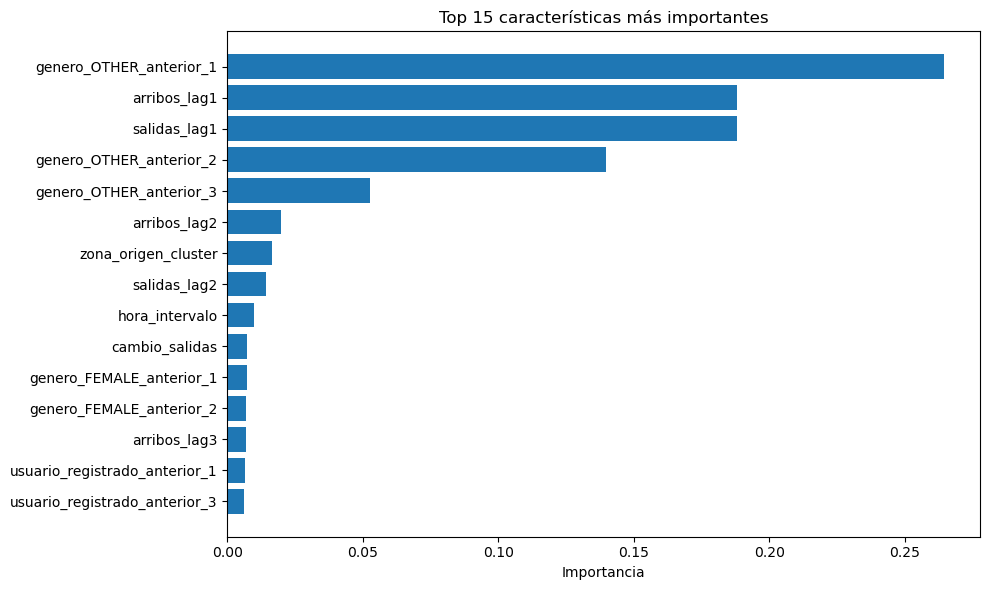

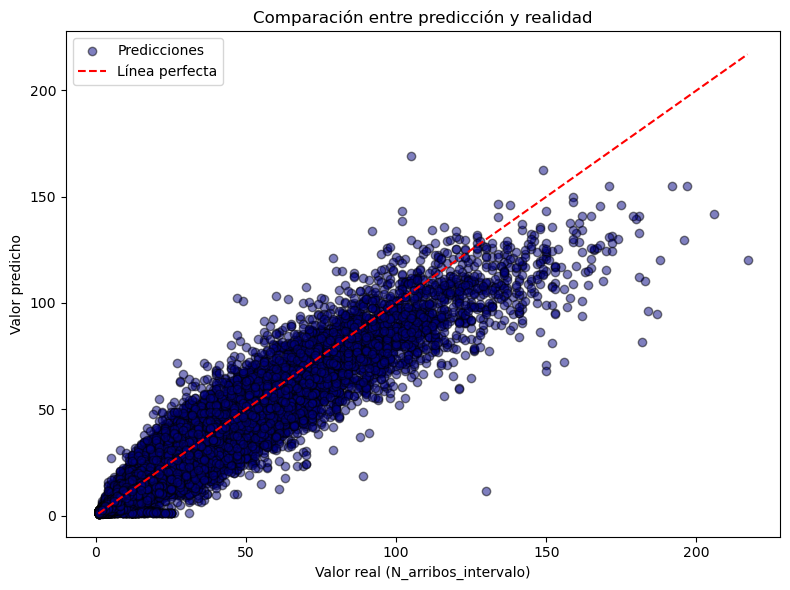


Ejemplos de validación:
 Real  Predicho (round)
  2.0          2.270887
  1.0          1.154806
  1.0          1.317507
  1.0          1.177172
  1.0          1.314451

=== ENTRENANDO PARA es_finde = 1 ===
  [Train] MAE: 0.0069
  [Train] R² : 1.0000
  [Val]   MAE: 1.6631
  [Val]   R² : 0.8630

🧠 El modelo está usando 45 features:
 1. zona_origen_cluster
 2. es_finde
 3. dia_semana
 4. hora_intervalo
 5. estacion_del_anio
 6. año_intervalo
 7. mes_intervalo
 8. dia_intervalo
 9. minuto_intervalo
10. edad_usuario_anterior_1
11. edad_usuario_anterior_2
12. edad_usuario_anterior_3
13. edad_usuario_rolling7
14. usuario_registrado_anterior_1
15. usuario_registrado_anterior_2
16. usuario_registrado_anterior_3
17. usuario_registrado_rolling7
18. genero_FEMALE_anterior_1
19. genero_FEMALE_anterior_2
20. genero_FEMALE_anterior_3
21. genero_FEMALE_rolling7
22. genero_MALE_anterior_1
23. genero_MALE_anterior_2
24. genero_MALE_anterior_3
25. genero_MALE_rolling7
26. genero_OTHER_anterior_1
27. gen

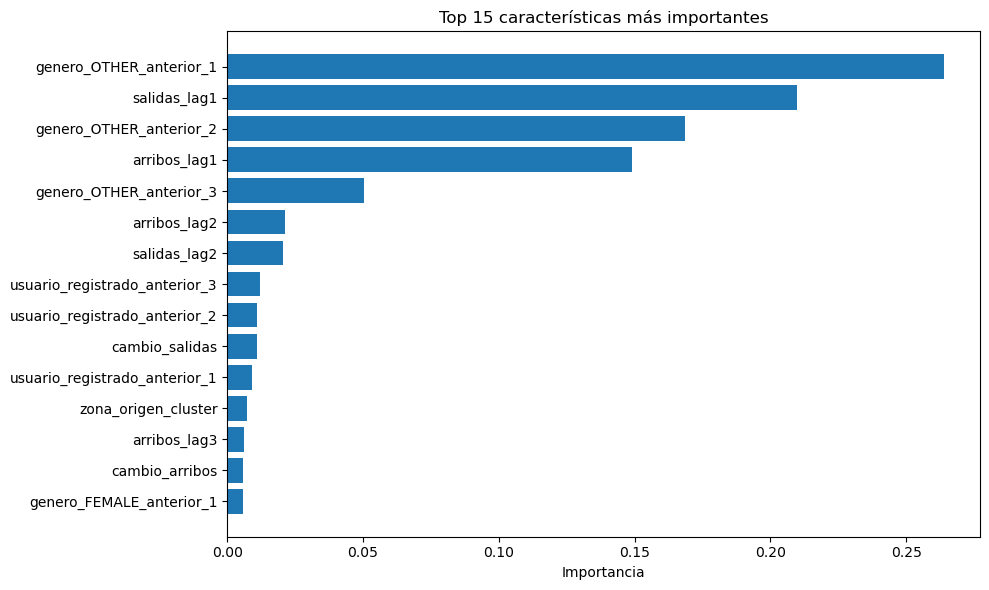

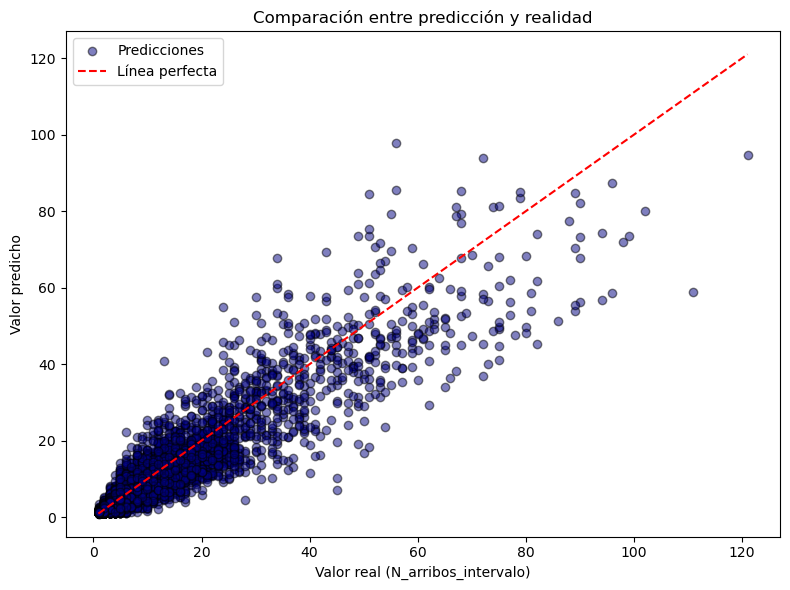


Ejemplos de validación:
 Real  Predicho (round)
  1.0          1.247459
  1.0          1.153162
  3.0          1.100930
  2.0          0.981929
  1.0          1.084973

=== MÉTRICAS DE VALIDACIÓN GLOBAL ===
MAE Global: 3.2197
R² Global:  0.9174
Resultados guardados en resultados_validacion.csv


In [12]:
modelos_finde_ZN, df_val_finde_ZN, y_val_finde_ZN, y_val_preds_finde_ZN, X_train_finde_ZN = entrenar_modelo_por_finde("data/modelado/ds_modelado_por_zona.parquet")